In [1]:
!pip install feature-engine

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from feature_engine import imputation as mdi
from feature_engine import encoding as ce

In [3]:
data = pd.read_csv(r'C:\Users\vish8\OneDrive\Desktop\Cursos\HyperparemetersCourse\Datasets\Titanic\train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# So I will take a shortcut and remove some features to make things simpler
cols = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
    'Embarked', 'Survived'
]

data = data[cols]

data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,7.2500,NaN,S,0
1,1,female,38.0,1,0,71.2833,C85,C,1
2,3,female,26.0,0,0,7.9250,NaN,S,1
3,1,female,35.0,1,0,53.1000,C123,S,1
4,3,male,35.0,0,0,8.0500,NaN,S,0


In [5]:
# Cabin: extract numerical and categorical part and delete original variable

data['cabin_num'] = data['Cabin'].str.extract('(\d+)') # captures numerical part
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['Cabin'].str[0] # captures the first letter

data.drop(['Cabin'], axis=1, inplace=True)

data.head()

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\vish8\AppData\Local\Temp\ipykernel_5040\2595449039.py:3: SyntaxWarning: invalid escape sequence '\d'
  data['cabin_num'] = data['Cabin'].str.extract('(\d+)') # captures numerical part


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,cabin_num,cabin_cat
0,3,male,22.0,1,0,7.2500,S,0,NaN,NaN
1,1,female,38.0,1,0,71.2833,C,1,85.0,C
2,3,female,26.0,0,0,7.9250,S,1,NaN,NaN
3,1,female,35.0,1,0,53.1000,S,1,123.0,C
4,3,male,35.0,0,0,8.0500,S,0,NaN,NaN


In [6]:
#make list of variables types
# we need these lists to indicate Feature-engine which variables to preprocess

#numerical : discreta
discrete = [ 
    var for var in data.columns if data[var].dtype != 'O' and var != 'Survived' and data[var].nunique() < 10
]

#Numerical : continua

continuous = [ 
    var for var in data.columns if data[var].dtype != 'O' and var != 'Survived' and var not in discrete
]

#Categorical
categorical = [
    var for var in data.columns if data[var].dtype == 'O'
]

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))


There are 3 discrete variables
There are 3 continuous variables
There are 3 categorical variables


In [7]:
discrete, continuous, categorical

(['Pclass', 'SibSp', 'Parch'],
 ['Age', 'Fare', 'cabin_num'],
 ['Sex', 'Embarked', 'cabin_cat'])

In [27]:
#Separete into training and testing set
X_train, X_test, y_train, y_test = train_test_split(data.drop('Survived', axis=1), data['Survived'], test_size=0.2, random_state=42)

X_train.shape, y_train.shape


((712, 9), (712,))

In [28]:
# Set up the pipeline

#Missing data imputation - we replace na in numerical variables
# Este pipeline realiza o pré-processamento e modelagem de dados para prever sobrevivência no Titanic.
# Ele contém as seguintes etapas:
#
# 1. Imputação de valores ausentes:
#    - Variáveis numéricas ('cabin_num', 'Fare', 'Age') têm os valores ausentes substituídos por -1
#      usando ArbitraryNumberImputer (feature-engine).
#    - Variáveis categóricas ('cabin_cat', 'Embarked') têm os valores ausentes imputados com a categoria
#      mais frequente usando CategoricalImputer (feature-engine).
#
# 2. Codificação de variáveis categóricas:
#    - RareLabelEncoder (category-encoders) agrupa categorias raras em uma única categoria para
#      'cabin_cat' e 'Embarked' (com limite de frequência < 1%).
#    - OrdinalEncoder (category-encoders) converte variáveis categóricas ('cabin_cat', 'Embarked', 'Sex')
#      em valores ordinais numéricos baseados em uma ordem predefinida.
#
# 3. Modelo de Machine Learning:
#    - GradientBoostingClassifier (scikit-learn) é usado como o estimador final para a previsão.
#
# Este pipeline automatiza o fluxo de pré-processamento e treinamento, garantindo que todas as etapas sejam
# aplicadas consistentemente.


titanic_pipe = Pipeline([
    ('imputer_nume', mdi.ArbitraryNumberImputer(arbitrary_number=-1, variables=['cabin_num', 'Fare', 'Age'])),
    ('imputer_cat', mdi.CategoricalImputer(variables=['cabin_cat', 'Embarked'])),#Categorical variables
    ('encoder_rare_label', ce.RareLabelEncoder(tol=0.01, n_categories=2, variables=['cabin_cat', 'Embarked'])), #categorical encoding
    ('categorical_encoder', ce.OrdinalEncoder(encoding_method='ordered', variables=['cabin_cat', 'Embarked','Sex'])), #categorical encoding
    ('gbm', GradientBoostingClassifier(random_state=42))
    

])

## Grid Search with Cross-Validation


In [32]:
param_grid = {
    'imputer_nume__arbitrary_number': [-1, 99],                     # Para imputação de números arbitrários
    'encoder_rare_label__tol': [0.1, 0.2],                         # Para ajuste de tolerância no RareLabelEncoder
    'imputer_cat__imputation_method': ['frequent', 'missing'],     # Para imputação de variáveis categóricas
    'categorical_encoder__encoding_method': ['ordered', 'arbitrary'],  # Método de codificação categórica
    'gbm__n_estimators': [10, 50, 100, 200],                      # Número de estimadores no GradientBoostingClassifier
    'gbm__max_depth': [None, 1, 3, 5, 10]                         # Profundidade máxima do GradientBoostingClassifier
}


In [33]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    titanic_pipe,
    param_grid,
    cv = 5,
    scoring = 'roc_auc'
)

In [34]:
grid_search.fit(X_train, y_train)

# and we print the best score over the train set
print(("best roc-auc from grid search: %.3f"
       % grid_search.score(X_train, y_train)))

best roc-auc from grid search: 0.923


In [35]:
print(("best linear regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

best linear regression from grid search: 0.868


In [36]:
grid_search.best_estimator_

Pipeline(steps=[('imputer_nume',
                 ArbitraryNumberImputer(arbitrary_number=99,
                                        variables=['cabin_num', 'Fare',
                                                   'Age'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['cabin_cat', 'Embarked'])),
                ('encoder_rare_label',
                 RareLabelEncoder(n_categories=2, tol=0.2,
                                  variables=['cabin_cat', 'Embarked'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['cabin_cat', 'Embarked', 'Sex'])),
                ('gbm',
                 GradientBoostingClassifier(n_estimators=50, random_state=42))])

In [37]:
grid_search.best_params_

{'categorical_encoder__encoding_method': 'ordered',
 'encoder_rare_label__tol': 0.2,
 'gbm__max_depth': 3,
 'gbm__n_estimators': 50,
 'imputer_cat__imputation_method': 'missing',
 'imputer_nume__arbitrary_number': 99}

In [38]:
# We also find the data for all models evaluated during the grid search
results = pd.DataFrame(grid_search.cv_results_)

print(results.shape)
results.head()

(320, 19)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_categorical_encoder__encoding_method,param_encoder_rare_label__tol,param_gbm__max_depth,param_gbm__n_estimators,param_imputer_cat__imputation_method,param_imputer_nume__arbitrary_number,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.046827,0.005826,0.006542,0.001338,ordered,0.1,None,10,frequent,-1,{'categorical_encoder__encoding_method': 'orde...,0.753849,0.745526,0.813971,0.806975,0.766835,0.777431,0.027908,277
1,0.043264,0.000772,0.005627,0.000584,ordered,0.1,None,10,frequent,99,{'categorical_encoder__encoding_method': 'orde...,0.691219,0.750832,0.771889,0.789061,0.831965,0.766993,0.046336,311
2,0.042668,0.000870,0.005710,0.000399,ordered,0.1,None,10,missing,-1,{'categorical_encoder__encoding_method': 'orde...,0.715772,0.738244,0.811215,0.813441,0.768203,0.769375,0.038823,303
3,0.042134,0.000933,0.005723,0.000248,ordered,0.1,None,10,missing,99,{'categorical_encoder__encoding_method': 'orde...,0.707553,0.750936,0.769557,0.795315,0.821128,0.768898,0.038761,304
4,0.180509,0.011323,0.005403,0.000193,ordered,0.1,None,50,frequent,-1,{'categorical_encoder__encoding_method': 'orde...,0.751352,0.721806,0.814819,0.803689,0.793981,0.777130,0.035029,278


Text(0.5, 0, 'Hyperparameter combinations')

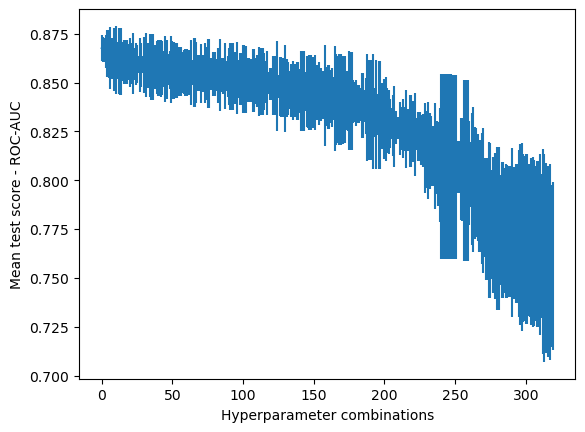

In [39]:
# we can order the different models based on their performance

results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)


# plot model performance and the generalization error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score - ROC-AUC')
plt.xlabel('Hyperparameter combinations')

<Axes: >

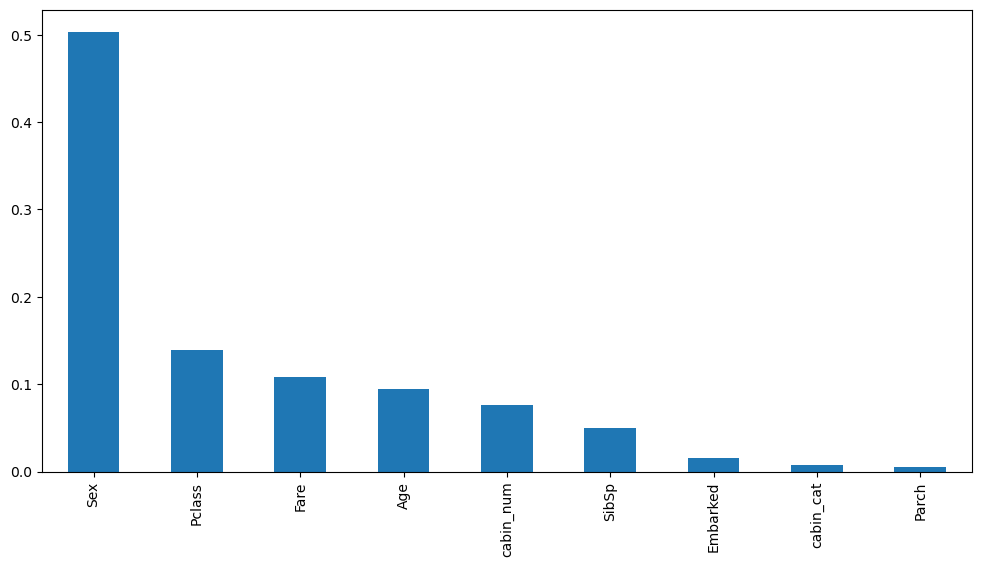

In [40]:
# and to wrap up:
# let's explore the importance of the features

importance = pd.Series(grid_search.best_estimator_['gbm'].feature_importances_)
importance.index = data.drop('Survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))